In [1]:
%matplotlib widget

In [80]:
# Imports
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats 
from numpy.lib.stride_tricks import sliding_window_view
from sklearn import metrics

import utils
import config

In [3]:
# Open data files
fname = []
for j in range(3):
    fname.append('steinmetz_part%d.npz'%j)

# Load data
data=utils.load_data(fname)

In [4]:
#dat_LFP = np.load('steinmetz_lfp.npz', allow_pickle=True)['dat']
#dat_WAV = np.load('steinmetz_wav.npz', allow_pickle=True)['dat']
dat_ST = np.load('steinmetz_st.npz', allow_pickle=True)['dat']

## Explore all datasets

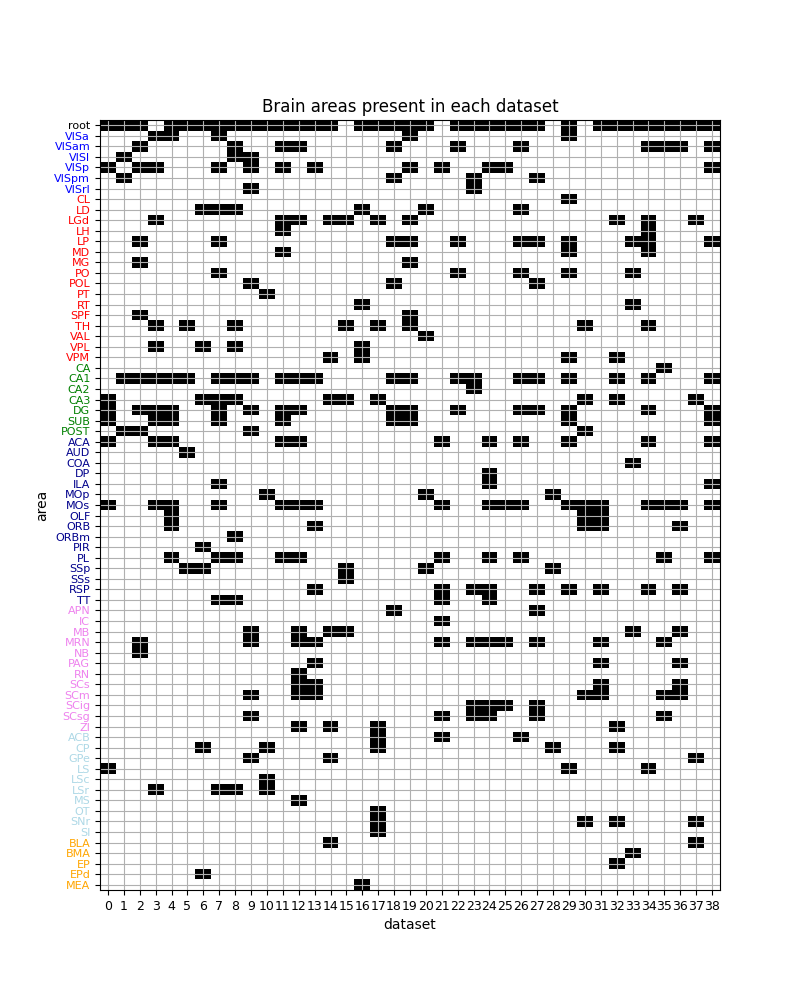

In [5]:
# Make a plot of which brain areas are present in each dataset

# Assign each area an index (region 4 does not correspond to brain_group 4)
area_to_index = dict(root=0)
counter = 1
for group in config.BRAIN_GROUPS:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(data)), dtype=bool)
for j, d in enumerate(data):
    for area in np.unique(d['brain_area']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in config.BRAIN_GROUPS:
  yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(data)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(config.BRAIN_GROUPS, config.REGION_COLORS):
  for area in group:
    ytickobjs[counter].set_color(color)
    counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)
plt.show()

In [6]:
for i in range(39):
    print("Mouse %d name: %s"%(i,data[i]['mouse_name']))

Mouse 0 name: Cori
Mouse 1 name: Cori
Mouse 2 name: Cori
Mouse 3 name: Forssmann
Mouse 4 name: Forssmann
Mouse 5 name: Forssmann
Mouse 6 name: Forssmann
Mouse 7 name: Hench
Mouse 8 name: Hench
Mouse 9 name: Hench
Mouse 10 name: Hench
Mouse 11 name: Lederberg
Mouse 12 name: Lederberg
Mouse 13 name: Lederberg
Mouse 14 name: Lederberg
Mouse 15 name: Lederberg
Mouse 16 name: Lederberg
Mouse 17 name: Lederberg
Mouse 18 name: Moniz
Mouse 19 name: Moniz
Mouse 20 name: Moniz
Mouse 21 name: Muller
Mouse 22 name: Muller
Mouse 23 name: Muller
Mouse 24 name: Radnitz
Mouse 25 name: Radnitz
Mouse 26 name: Radnitz
Mouse 27 name: Radnitz
Mouse 28 name: Radnitz
Mouse 29 name: Richards
Mouse 30 name: Richards
Mouse 31 name: Richards
Mouse 32 name: Richards
Mouse 33 name: Richards
Mouse 34 name: Tatum
Mouse 35 name: Tatum
Mouse 36 name: Tatum
Mouse 37 name: Tatum
Mouse 38 name: Theiler


## Explore one dataset

In [7]:
mice=11

In [8]:
dataset = data[mice]
print(dataset.keys())
print(" ")
print(dat_ST[mice].keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])
 
dict_keys(['ss', 'ss_passive'])


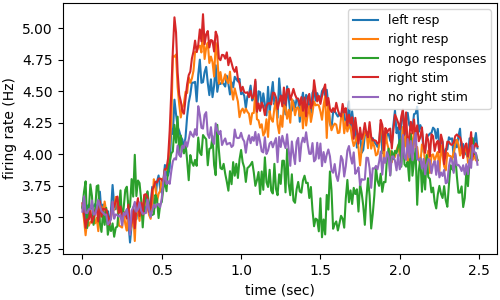

In [9]:
# mean firing rate of all neurons during diferent trial conditions 

dt = dataset['bin_size']  # binning at 10 ms
NT = dataset['spks'].shape[-1]

fig,ax = plt.subplots(figsize=(5, 3))
# Trials conditions
response = dataset['response']  # right - nogo - left (-1, 0, 1)
vis_right = dataset['contrast_right']  # 0 - low - high
vis_left = dataset['contrast_left']  # 0 - low - high

plt.plot(dt * np.arange(NT), 1/dt * dataset['spks'][:, response > 0].mean(axis=(0, 1)))  # left responses
plt.plot(dt * np.arange(NT), 1/dt * dataset['spks'][:, response < 0].mean(axis=(0, 1)))  # right responses
plt.plot(dt * np.arange(NT), 1/dt * dataset['spks'][:, response == 0].mean(axis=(0, 1)))  # nogo responses

plt.plot(dt * np.arange(NT), 1/dt * dataset['spks'][:, vis_right > 0].mean(axis=(0, 1)))  # stimulus on the right
plt.plot(dt * np.arange(NT), 1/dt * dataset['spks'][:, vis_right == 0].mean(axis=(0, 1)))  # no stimulus on the right

plt.legend(['left resp', 'right resp','nogo responses', 'right stim', 'no right stim'], fontsize=9)
ax.set(xlabel='time (sec)', ylabel='firing rate (Hz)')
fig.tight_layout(pad=0.2, h_pad=1.3, w_pad=1.3)
plt.show()

### Brain areas

In [10]:
np.unique(dataset['brain_area'])

array(['ACA', 'CA1', 'DG', 'LGd', 'LH', 'MD', 'MOs', 'PL', 'SUB', 'VISam',
       'VISp', 'root'], dtype='<U5')

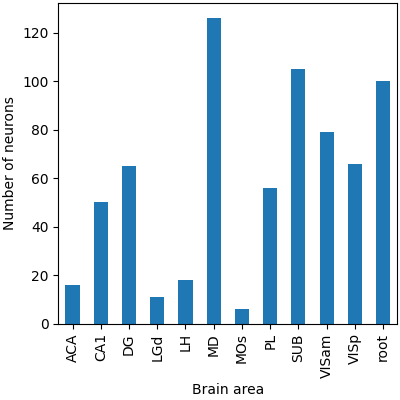

In [11]:
fig, ax = plt.subplots()
unique, counts = np.unique(dataset['brain_area'], return_counts=True)
pd.DataFrame.from_dict(dict(zip(unique, counts)),orient='index').plot(kind='bar',figsize=(4, 4),legend=False,ax=ax)
ax.set(xlabel='Brain area', ylabel='Number of neurons')
fig.tight_layout(pad=0.2, h_pad=1.3, w_pad=1.3)
plt.show()

In [22]:
nareas = len(config.BRAIN_GROUPS)#
NN = len(dataset['brain_area'])  # number of neurons
barea = 7 * np.ones(NN, )  # 7 is "other ctx", neurons that were not able to be classified
for j in range(nareas):
  barea[np.isin(dataset['brain_area'], config.BRAIN_GROUPS[j])] = j  # assign a number to each region

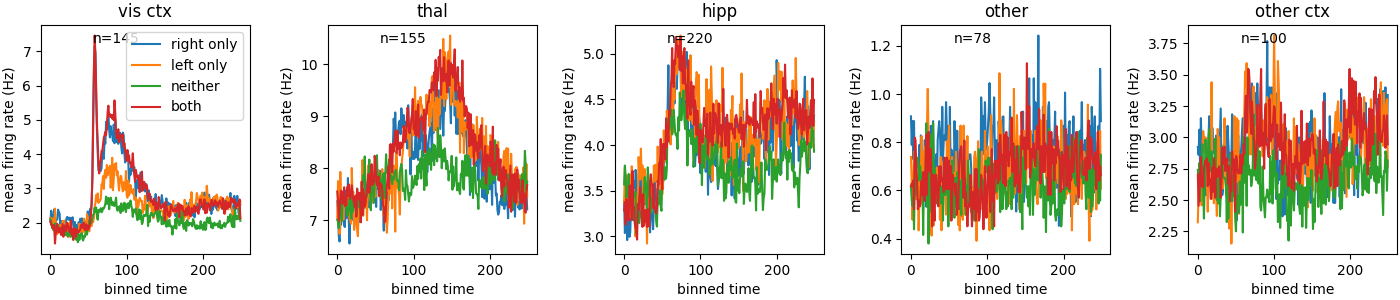

In [25]:
fig,ax = plt.subplots(nrows=1, ncols=len(np.unique(barea)),figsize=(14,3))
for j,i_narea in enumerate(np.unique(barea).astype(int)):
  
  ax[j].plot(1/dt * dataset['spks'][barea==i_narea][:, np.logical_and(vis_left == 0, vis_right > 0)].mean(axis=(0, 1)))
  ax[j].plot(1/dt * dataset['spks'][barea==i_narea][:, np.logical_and(vis_left > 0, vis_right == 0)].mean(axis=(0, 1)))
  ax[j].plot(1/dt * dataset['spks'][barea==i_narea][:, np.logical_and(vis_left == 0, vis_right == 0)].mean(axis=(0, 1)))
  ax[j].plot(1/dt * dataset['spks'][barea==i_narea][:, np.logical_and(vis_left > 0, vis_right > 0)].mean(axis=(0, 1)))
  ax[j].text(.25, .92, 'n=%d'%np.sum(barea == i_narea), transform=ax[j].transAxes)
  if j==0:
    ax[j].legend(['right only', 'left only', 'neither', 'both'], fontsize=10)
  ax[j].set(xlabel='binned time', ylabel='mean firing rate (Hz)', title=config.REGIONS[i_narea])

fig.tight_layout(pad=0.2, h_pad=1.3, w_pad=1.3)
plt.show()

### Events

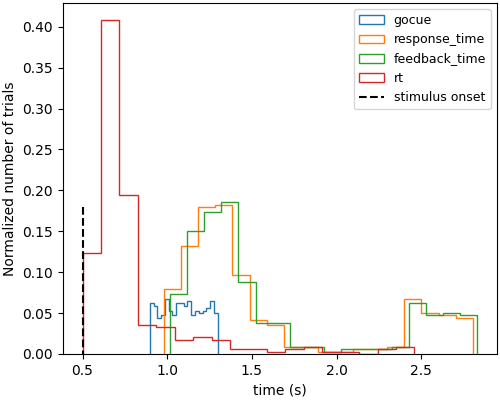

stimulus onset: 0.5
reaction_time mean: 0.79
gocue mean: 1.10
response_time mean: 1.59
feedback_time mean: 1.62


In [14]:
fig, ax = plt.subplots(figsize=(5, 4))
#unique, counts = np.unique(dataset['gocue'], return_counts=True)
weights = np.ones_like(dataset['gocue'])/float(len(dataset['gocue']))
ax.hist(dataset['gocue']+0.5,weights=weights,histtype="step",bins=int(np.sqrt(len(dataset['feedback_time']))))
weights = np.ones_like(dataset['response_time'])/float(len(dataset['response_time']))
ax.hist(dataset['response_time']+0.5,bins=int(np.sqrt(len(dataset['feedback_time']))),histtype="step",weights=weights)
weights = np.ones_like(dataset['feedback_time'])/float(len(dataset['feedback_time']))
ax.hist(dataset['feedback_time']+0.5,bins=int(np.sqrt(len(dataset['feedback_time']))),histtype="step",weights=weights)

weights = np.ones_like(dataset['reaction_time'][:,0])/float(len(dataset['reaction_time'][:,0]))
ax.hist(np.where(dataset['reaction_time'][:,0]==np.inf,np.nan,dataset['reaction_time'][:,0]/1000)+0.5,bins=int(np.sqrt(len(dataset['reaction_time'][:,0]))),histtype="step",weights=weights)

ax.vlines(0.5,0.18,0,color="k",linestyles="--")

ax.set(xlabel='time (s)', ylabel='Normalized number of trials')
plt.legend(['gocue', 'response_time','feedback_time',"rt", 'stimulus onset'], fontsize=9)
fig.tight_layout(pad=0.2, h_pad=1.3, w_pad=1.3)
plt.show()

print("stimulus onset: 0.5")# stimulus onset 0.5
print("reaction_time mean: %0.2f"%(np.nanmean(np.where(dataset['reaction_time'][:,0]==np.inf,np.nan,dataset['reaction_time'][:,0]/1000))+0.5))# reaction time
print("gocue mean: %0.2f"%(dataset['gocue'].mean()+0.5))# go cue 1.1
print("response_time mean: %0.2f"%(dataset['response_time'].mean()+0.5))# response 1.54
print("feedback_time mean: %0.2f"%(dataset['feedback_time'].mean()+0.5))# feedback

Mouse name:  Lederberg


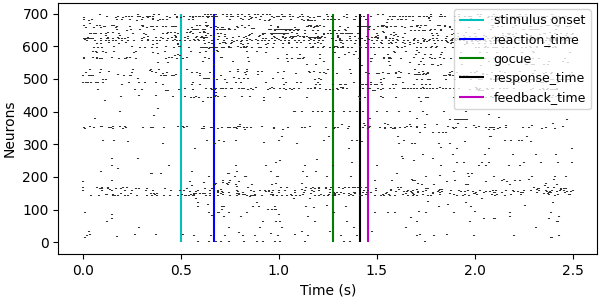

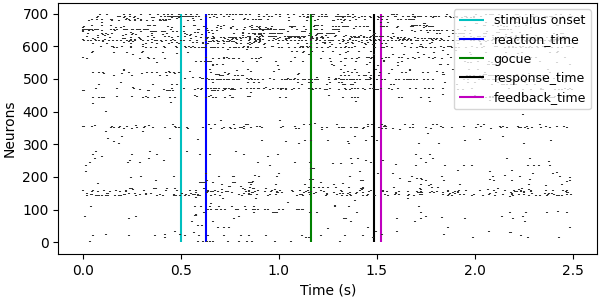

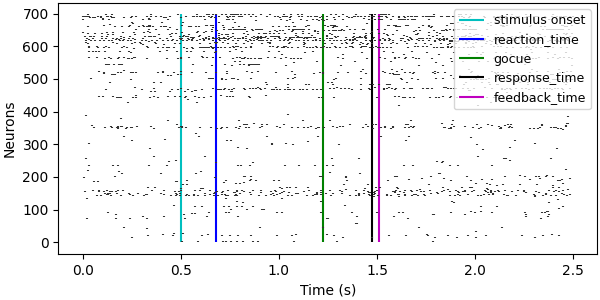

In [15]:
dataset_ST = dat_ST[mice]

print("Mouse name: ",dataset['mouse_name'])

idx = np.where(np.logical_and(vis_left == 0, vis_right > 0))[0] 
trial_dat_raster_ST=dataset_ST['ss'][:,idx]

for i_trial in range(0,3):#trial_dat_raster_ST.shape[1]
  a=utils.plot_raster(dataset,trial_dat_raster_ST,i_trial=i_trial,idx=idx)

### Take spikes from all datasets

In [333]:
def check_neuron_activation(neurons,passive_neurons):

    diff_n = ( neurons.mean(axis=2).T -  passive_neurons.mean(axis=2)[:,0]).T

    return np.where(diff_n> 0)


In [334]:
def select_areas_firing(data_area,mask_trials):

    areas = []#np.unique(data_area['brain_area'])
    areas_firing = []

    nareas = len(config.BRAIN_GROUPS)
    NN = len(data_area['brain_area'])  # number of neurons
    barea = 7 * np.ones(NN, )  # 7 is "other ctx", neurons that were not able to be classified
    for j in range(nareas):
        barea[np.isin(data_area['brain_area'], config.BRAIN_GROUPS[j])] = j  # assign a number to each region
    

    for j,i_narea in enumerate(np.unique(barea).astype(int)):
        if i_narea != 7:
            area_spks = data_area['spks'][barea==i_narea][:,mask_trials ]
            area_passive_spks = data_area['spks'][barea==i_narea][:, mask_trials]
            area_spks = area_spks[check_neuron_activation(neurons=area_spks,passive_neurons=area_passive_spks)].reshape(-1,250)#
            
            areas_firing.append(area_spks)#.mean(axis=0))#/max(area_spks.mean(axis=0)))
            areas.append(config.REGIONS[i_narea])
        
    return areas,areas_firing


In [367]:
def plot_areas_spks(firing_areas,areas_unique):
    fig,ax = plt.subplots(figsize=(14, 3))

    mean_firing_areas = np.zeros((len(firing_areas),firing_areas[0].shape[1]))

    for i in range(len(firing_areas)):
    
        mean_firing_areas[i] = np.array(firing_areas[i]).mean(axis=0)/max(np.array(firing_areas[i]).mean(axis=0))


    sns.heatmap(mean_firing_areas, vmin=0,ax=ax,cmap="Blues")#(dt * np.arange(NT), ) 
    ax.set_yticklabels(areas_unique, rotation=0)
    ax.vlines([50], *ax.get_ylim(),color='r')
    ax.vlines([79], *ax.get_ylim(),color='b')
    ax.vlines([110], *ax.get_ylim(),color='g')
    ax.vlines([159], *ax.get_ylim(),color='y')

    ax.plot(np.argmax(mean_firing_areas, axis=0)+0.5,color='k')

    plt.legend(['stimulus onset','reaction_time','gocue', 'response_time'], fontsize=9)
    ax.set(xlabel='timebins (10 ms)')
    fig.tight_layout(pad=0.2, h_pad=1, w_pad=1)
    plt.show()

In [368]:
all_areas = []
all_areas_firing=[]

for i in range(39):
    data_n = data[i]

    response_area = data_n['response']  # right - nogo - left (-1, 0, 1)
    vis_right_area = data_n['contrast_right']  # 0 - low - high
    vis_left_area = data_n['contrast_left']  # 0 - low - high
    # stimulus on the right, response right (correct responses)
    mask_trials = np.logical_and(vis_left_area == 0, vis_right_area > 0,response_area ==-1)
    areas,areas_firing = select_areas_firing(data_n,mask_trials)
    all_areas.append(areas)
    all_areas_firing.append(areas_firing)

firing_area_n=[]
firing_areas =[]
areas_unique = np.unique(np.concatenate(all_areas))

for i_area in areas_unique:
    i=0
    j=0 
    firing_area_n=[]
    for i_dataset in range(len(all_areas)): # search one area in each dataset
        idx = np.where(np.array(all_areas[i_dataset]) == i_area)[0]
       
        if idx.shape[0] !=0: 

            firing_area_n.append(all_areas_firing[i_dataset][idx[0]])

    firing_areas.append(np.concatenate(firing_area_n))#(firing_area_n) # each element in the list correspond to one area and contain fr of all datasets



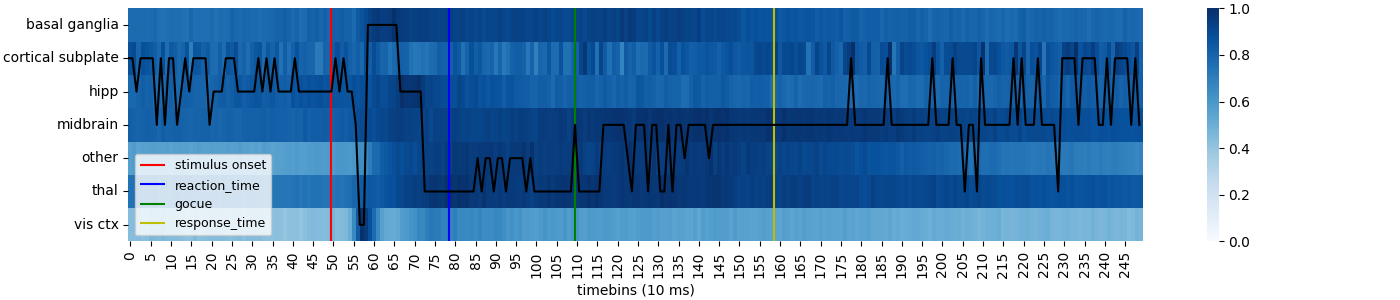

In [369]:
plot_areas_spks(firing_areas,areas_unique)

In [355]:
all_areas = []
all_areas_firing=[]

for i in range(39):
    data_n = data[i]

    response_area = data_n['response']  # right - nogo - left (-1, 0, 1)
    vis_right_area = data_n['contrast_right']  # 0 - low - high
    vis_left_area = data_n['contrast_left']  # 0 - low - high
    feedback_area = data_n['feedback_type'] # 1 reward - -1 noise
    # stimulus on the left, response left (correct responses)
    mask_trials = np.logical_and(vis_left_area > 0, vis_right_area == 0,response_area ==1)
    areas,areas_firing = select_areas_firing(data_n,mask_trials)
    all_areas.append(areas)
    all_areas_firing.append(areas_firing)

firing_area_n=[]
firing_areas =[]
areas_unique = np.unique(np.concatenate(all_areas))

for i_area in areas_unique:
    i=0
    j=0 
    firing_area_n=[]
    for i_dataset in range(len(all_areas)): # search one area in each dataset
        idx = np.where(np.array(all_areas[i_dataset]) == i_area)[0]
       
        if idx.shape[0] !=0: 

            firing_area_n.append(all_areas_firing[i_dataset][idx[0]])

    firing_areas.append(np.concatenate(firing_area_n))#(firing_area_n) # each element in the list correspond to one area and contain fr of all datasets

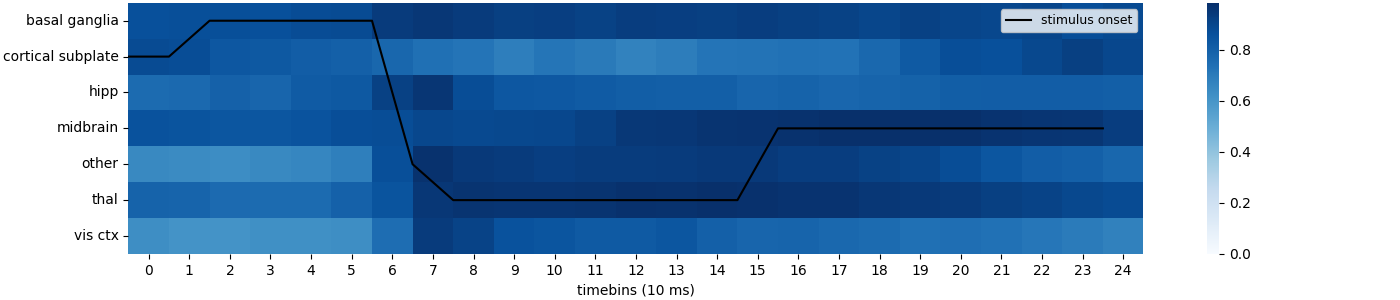

In [356]:
plot_areas_spks(firing_areas,areas_unique)

In [357]:
all_areas = []
all_areas_firing=[]

for i in range(39):
    data_n = data[i]

    response_area = data_n['response']  # right - nogo - left (-1, 0, 1)
    vis_right_area = data_n['contrast_right']  # 0 - low - high
    vis_left_area = data_n['contrast_left']  # 0 - low - high
    feedback_area = data_n['feedback_type'] # 1 reward - -1 noise
    # stimulus on the left, response left (correct responses)
    mask_trials = feedback_area== 1#np.logical_and( feedback_area== 1)
    areas,areas_firing = select_areas_firing(data_n,mask_trials)
    all_areas.append(areas)
    all_areas_firing.append(areas_firing)

firing_area_n=[]
firing_areas =[]
areas_unique = np.unique(np.concatenate(all_areas))

for i_area in areas_unique:
    i=0
    j=0 
    firing_area_n=[]
    for i_dataset in range(len(all_areas)): # search one area in each dataset
        idx = np.where(np.array(all_areas[i_dataset]) == i_area)[0]
       
        if idx.shape[0] !=0: 

            firing_area_n.append(all_areas_firing[i_dataset][idx[0]])

    firing_areas.append(np.concatenate(firing_area_n))#(firing_area_n) # each element in the list correspond to one area and contain fr of all datasets

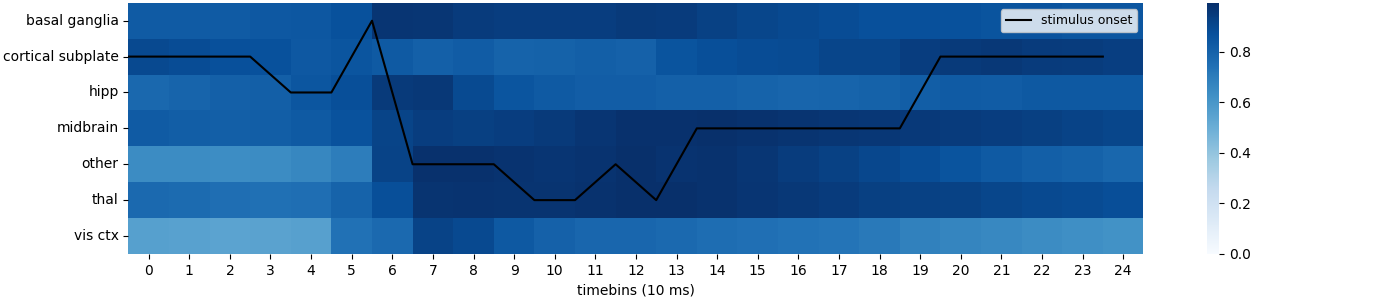

In [358]:
plot_areas_spks(firing_areas,areas_unique)

In [ ]:
plt.close('all')